# Mixed Monotonic

---

---

### Overview

This notebook trains a similar network to [simple_mlp](./simple_mlp.ipynb), but with a monotonic constraint on just the features `x1` and `x2`.  `x3` continues to enter as an embedding, and `x4` enters the model as a continuous feature without any monotonic constraints.

This notebook illustrates the use of Orthonormal Certificates to estimate epistemic uncertainty based on the training data provided to the model.

Notice:
- We're importing `MixedMonotonicNet()` from `tabularasa`.  This is a predefined network that takes a user-defined network as input, and combines that network's output with montonic features and a special monotonic network to generate predictions.
- We're importing `MixedMonotonicRegressor()` from `tabularasa`.  This isn't strictly necessary, and `MixedMonotonicNet()` could be trained with `skorch.NeuralNetRegressor()` (or even the standard PyTorch API).  In fact, `MixedMonotonicRegressor()` is defined to inherit the `skorch.NeuralNet()` class and is very similar to `NeuralNetRegressor()`, with the exception of special arguments needed to generate Orthonormal Certificates.
- `OrthonormalCertificatesNet()` and `OrthonormalCertificatesRegressor()` exist are similarly specialized.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tabularasa.MixedMonotonic import MixedMonotonicRegressor, MixedMonotonicNet
from tabularasa.OrthonormalCertificates import OrthonormalCertificatesRegressor, OrthonormalCertificatesNet

---

### Load example data

If you haven't already, please generate the example dataset using the [example_data](example_data.ipynb) notebook.

In [2]:
df = pd.read_pickle('./data/simple_train.pkl')

---

### Define the user-specified network and model

Notice:
- Similar to [simple_mlp](simple_mlp.ipynb) we have a small embedding layer and then pass those embeddings as well as `x4` through a linear layer with ReLU activation.  Theoretically, this network could be much deeper and more complex, but for speed of training, we'll keep it simple.
- `x1` and `x2` are monotonically constrained, so are not sent through `EmbeddingNet()`.
- The `.forward()` method requires exactly one input that must be named `X_non_monotonic`.  This requires the suboptimal step of parsing the features by column index and converting types.  Note that the `TabulaRasaRegressor()`, show in [tabula_rasa](./tabula_rasa.ipynb), handles this for you.

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1, None].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

In [4]:
model = MixedMonotonicRegressor(MixedMonotonicNet,
                                max_epochs=150,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                iterator_train__shuffle=True,
                                module__non_monotonic_net=EmbeddingNet(),
                                module__dim_non_monotonic=16,
                                module__dim_monotonic=2,
                                module__layers=[128, 128, 32],
                                module__integration_steps=300)

In [5]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_non_monotonic': df[['x3', 'x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.8125        0.3759  6.8594
      2        0.3213        0.3280  6.8138
      3        0.3159        0.3151  8.6125
      4        0.3107        0.3164  7.2664
      5        0.3048        0.3049  7.1048
      6        0.2941        0.2975  6.9855
      7        0.2896        0.2925  7.0343
      8        0.2829        0.2853  7.0459
      9        0.2739        0.2732  7.0315
     10        0.2606        0.2568  7.1826
     11        0.2477        0.2462  6.8660
     12        0.2338        0.2343  7.0656
     13        0.2212        0.2213  7.2133
     14        0.2070        0.2065  7.0202
     15        0.1899        0.1926  6.8297
     16        0.1691        0.1734  7.1091
     17        0.1490        0.1618  7.1654
     18        0.1310        0.1518  7.1297
     19        0.1167        0.1444  7.0841
     20        0.1050        0.1346  7.1743
     21        0.0950        0.1

<class 'tabularasa.MixedMonotonic.MixedMonotonicRegressor'>[initialized](
  module_=MixedMonotonicNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
            (6): Linear(

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_non_monotonic': dfc[['x3', 'x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

NameError: name 'torch' is not defined

In [ ]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

### Estimate epistemic uncertainty via orthonormal certificates

Start by prepping data from the inner hidden layer.

In [9]:
model.module_.set_last_layer(inner=True)

In [21]:
X_inner = model.predict({'X_monotonic': df[['x1', 'x2']].values,
                         'X_non_monotonic': df[['x3', 'x4']].values})

Now train orthonormal certificates.  Note, including raw numeric features helps quality.

In [24]:
oc = OrthonormalCertificates()
oc.fit(np.concatenate([df[['x1', 'x2', 'x4']].values, X_inner], axis=1))

Create another PDP like dataset with the full range.

In [31]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = oc.transform(np.concatenate([dfc[['x1', 'x2', 'x4']],
                                     model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                                                    'X_non_monotonic': dfc[['x3', 'x4']].values})], axis=1))
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

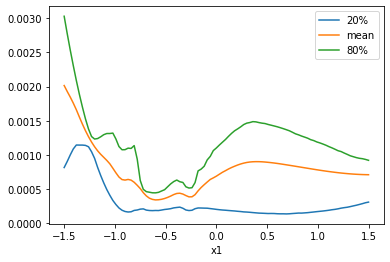

In [32]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

Epistemic uncertainty is high below -1 (where training data starts and is relatively low), decreases between -1 and 0, picks back up between 0 and 0.5, and then decreases between 0.5 and 1.  After 1, it doesn't perform exactly as desired, but is ticking up in some places.